In [87]:
#import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow  as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


from sklearn.metrics import mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import *
import os

In [88]:
#see if gpu is avaible
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [89]:
#get data and filtere it 
frame = pd.read_csv(r'weekcount.csv')
df = pd.DataFrame(frame)
df.drop(df[df['year'] == 2020].index, inplace = True) #'REMOVE2020'
#df.drop(df[df['year'] == 2015].index, inplace = True) #remove 2015
#df.drop(df[df['year'] == 2019].index, inplace = True) #'REMOVE2020'
test = pd.DataFrame(df)
 
#reading and dumming datta
col = list(df.columns.values)

 



In [90]:
#get weather data
wframe = pd.read_csv(r'weather.csv')
weather = pd.DataFrame(wframe)
weather.head()

year  week  sunHour  totalSnow_cm  FeelsLikeC  cloudcover  humidity  \
0  2015    39    10.00           0.0       18.57       37.86     66.00   
1  2015    40     8.57           0.0       14.86       69.29     82.14   
2  2015    41     9.31           0.0       16.29       25.00     71.57   
3  2015    42     8.70           0.0       12.29       17.00     65.57   
4  2015    43     7.81           0.0       12.29       27.29     68.00   

   precipMM  tempC  windspeedKmph  
0      0.00  21.86          13.57  
1      4.73  18.14          22.43  
2      0.71  19.57          11.71  
3      0.07  16.29          15.71  
4      0.56  16.57          16.29

In [91]:
#merge both DF
df = pd.merge(df,weather,on=['year','week'],how='outer').dropna()
#df = df.reset_index()
print(df[df.index.duplicated()])
 
df

Empty DataFrame
Columns: [year, week, station, anzahl, sunHour, totalSnow_cm, FeelsLikeC, cloudcover, humidity, precipMM, tempC, windspeedKmph]
Index: []


year  week                station  anzahl  sunHour  totalSnow_cm  \
0      2015    39      5 Corners Library    43.0    10.00           0.0   
1      2015    39  Baldwin at Montgomery    66.0    10.00           0.0   
2      2015    39           Bayside Park    16.0    10.00           0.0   
3      2015    39           Brunswick St   186.0    10.00           0.0   
4      2015    39            Central Ave    25.0    10.00           0.0   
...     ...   ...                    ...     ...      ...           ...   
10464  2019    52               Union St    10.0     7.94           0.0   
10465  2019    52         Van Vorst Park    82.0     7.94           0.0   
10466  2019    52              Warren St   126.0     7.94           0.0   
10467  2019    52          Washington St   101.0     7.94           0.0   
10468  2019    52                York St    30.0     7.94           0.0   

       FeelsLikeC  cloudcover  humidity  precipMM  tempC  windspeedKmph  
0           18.57       37.86     66.00      0.00  21.86          13.57  
1           18.57       37.86     66.00      0.00  21.86          13.57  
2           18.57       37.86     66.00      0.00  21.86          13.57  
3           18.57       37.86     66.00      0.00  21.86          13.57  
4           18.57       37.86     66.00      0.00  21.86          13.57  
...           ...         ...       ...       ...    ...            ...  
10464        3.57       32.57     72.14      0.14   7.29           9.29  
10465        3.57       32.57     72.14      0.14   7.29           9.29  
10466        3.57       32.57     72.14      0.14   7.29           9.29  
10467        3.57       32.57     72.14      0.14   7.29           9.29  
10468        3.57       32.57     72.14      0.14   7.29           9.29  

[10469 rows x 12 columns]

In [92]:
#get input and output
x = df.drop("anzahl",axis=1)
y = df["anzahl"]

In [93]:
#split data into train and test
x_train, x_test ,y_train , y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

In [94]:
#normalisie data
ct = make_column_transformer(
 (MinMaxScaler(),["year","week","sunHour", "totalSnow_cm", "FeelsLikeC", "cloudcover", "humidity", "precipMM", "tempC", "windspeedKmph"]),
     (OneHotEncoder(handle_unknown="ignore"),["station"])
 )

ct.fit(x_train)

x_train_normalized = ct.transform(x_train)

x_test_normalized = ct.transform(x_test)

x_train_normalized.shape

(8375, 73)

In [25]:
#load saved model if avaiable 
with tf.device('/device:CPU:0'):
    model = keras.models.load_model('Model2')

In [121]:
#create Model structure
with tf.device('/device:CPU:0'):
    model = Sequential()
    model.add(Dense(1000, kernel_initializer='normal',  activation='relu', input_shape=(73,) ))
    #model.add(Dropout(0.3))
    model.add(Dense(500, kernel_initializer='normal',activation='relu'))
   # model.add(Dropout(0.3))
    model.add(Dense(200, kernel_initializer='normal',activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal',activation=None))

In [122]:
#set model loss and optimizer
with tf.device('/device:CPU:0'):
    model.compile(optimizer= Adam(learning_rate=0.001),loss='mae', metrics=['mae','mape'])

In [28]:
#checkpoint to save best Model which isnt overfitted
checkpoint = ModelCheckpoint('Model2', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min' )

In [123]:
#train Model
with tf.device('/device:CPU:0'):
    history = model.fit(x_train_normalized, y_train.values, epochs=10 , batch_size=1,shuffle=True   )

Epoch 1/10
8375/8375 [==============================] - 15s 2ms/step - loss: 41.4206 - mae: 41.4206 - mape: 108.3876
Epoch 2/10
8375/8375 [==============================] - 15s 2ms/step - loss: 23.9662 - mae: 23.9662 - mape: 36.4377
Epoch 3/10
8375/8375 [==============================] - 15s 2ms/step - loss: 21.0828 - mae: 21.0828 - mape: 33.5685
Epoch 4/10
8375/8375 [==============================] - 15s 2ms/step - loss: 20.3583 - mae: 20.3583 - mape: 31.5905
Epoch 5/10
8375/8375 [==============================] - 15s 2ms/step - loss: 19.4186 - mae: 19.4186 - mape: 29.3237
Epoch 6/10
8375/8375 [==============================] - 15s 2ms/step - loss: 18.4505 - mae: 18.4505 - mape: 28.2342
Epoch 7/10
8375/8375 [==============================] - 15s 2ms/step - loss: 17.6393 - mae: 17.6393 - mape: 27.5514
Epoch 8/10
8375/8375 [==============================] - 15s 2ms/step - loss: 17.5460 - mae: 17.5460 - mape: 28.0986
Epoch 9/10
8375/8375 [==============================] - 15s 2ms/step - 

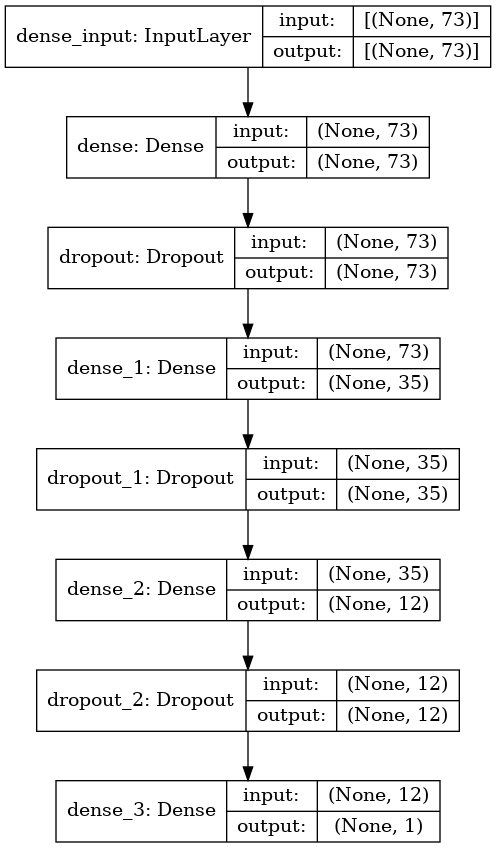

In [12]:
tf.keras.utils.plot_model(model,    show_shapes=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 73)                5402      
_________________________________________________________________
dropout (Dropout)            (None, 73)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                2590      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                432       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [124]:
model.evaluate(x_test_normalized,y_test.values)

66/66 [==============================] - 1s 11ms/step - loss: 29.9702 - mae: 29.9702 - mape: 32.5419


[29.970186233520508, 29.970186233520508, 32.54191970825195]

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Anzahl]')
    plt.legend()
    plt.grid(True)

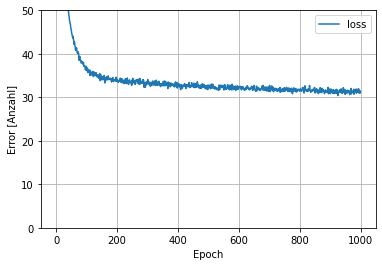

In [16]:
with tf.device('/device:CPU:0'):
    plot_loss(history)

In [17]:
stationnamesframe =   test.drop_duplicates() 
stationnamesframe = pd.DataFrame(stationnamesframe,columns=['station'])
stationnamesframe =   stationnamesframe.drop_duplicates() 
stationnames =  pd.DataFrame(stationnamesframe , columns=['station'])['station'].to_numpy().tolist()
print(stationnames)

['5 Corners Library', 'Baldwin at Montgomery', 'Bayside Park', 'Brunswick St', 'Central Ave', 'Christ Hospital', 'City Hall', 'Columbia Park', 'Dey St', 'Essex Light Rail', 'Exchange Place', 'Garfield Ave Station', 'Grove St PATH', 'Hamilton Park', 'Heights Elevator', 'Hilltop', 'JC Medical Center', 'Liberty Light Rail', 'Lincoln Park', 'MLK Light Rail', 'McGinley Square', 'NJCU', 'Newark Ave', 'Newport PATH', 'Newport Pkwy', 'North St', 'Oakland Ave', 'Paulus Hook', 'Pershing Field', 'Riverview Park', 'Sip Ave', 'Union St', 'Van Vorst Park', 'Warren St', 'West Side Light Rail', 'Jersey & 3rd', 'Jersey & 6th St', 'Lafayette Park', 'Morris Canal', 'Bethune Center', 'Columbus Drive', 'Danforth Light Rail', 'Dixon Mills', 'Leonard Gordon Park', 'Manila & 1st', 'Marin Light Rail', 'Monmouth and 6th', 'Astor Place', 'Brunswick & 6th', 'JCBS Depot', 'Communipaw & Berry Lane', 'York St', 'Harborside', 'Journal Square', 'Washington St', 'Bergen Ave', 'Fairmount Ave', 'Glenwood Ave', 'Grand St'

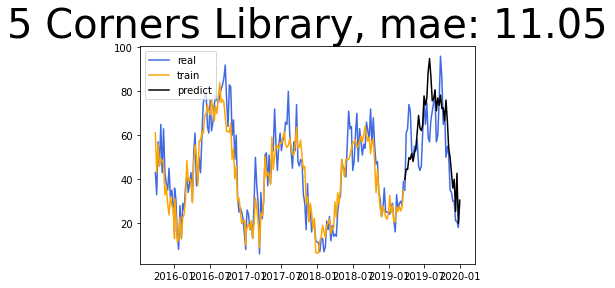

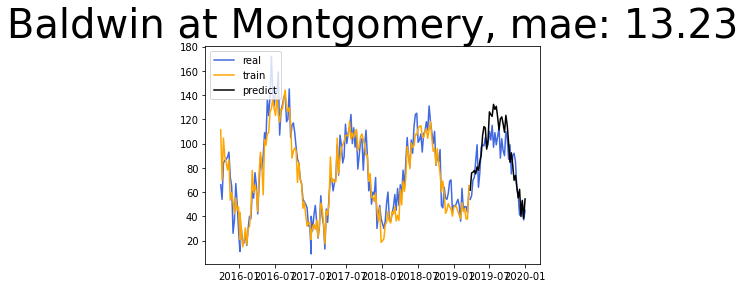

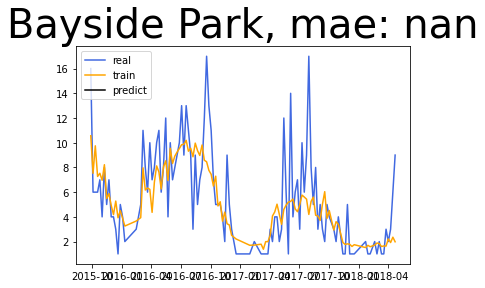

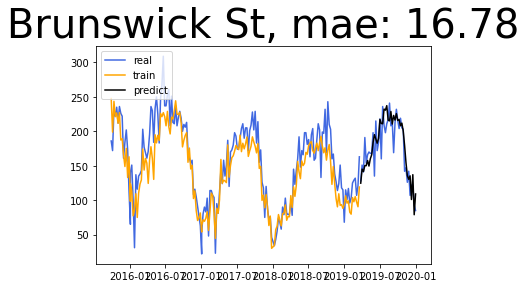

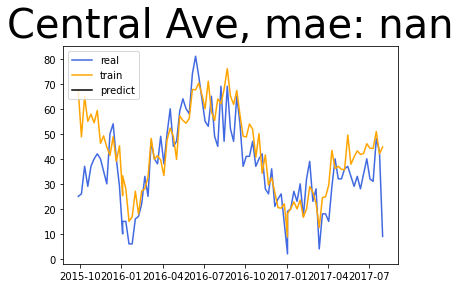

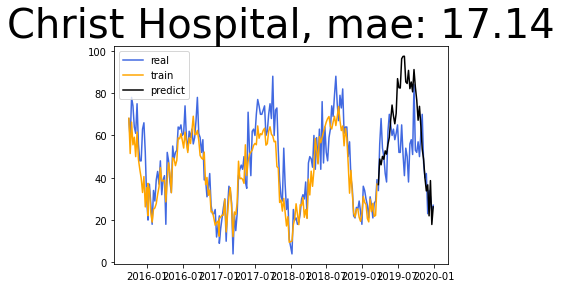

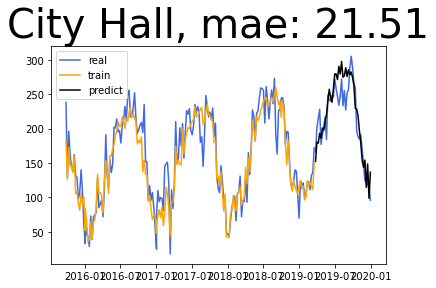

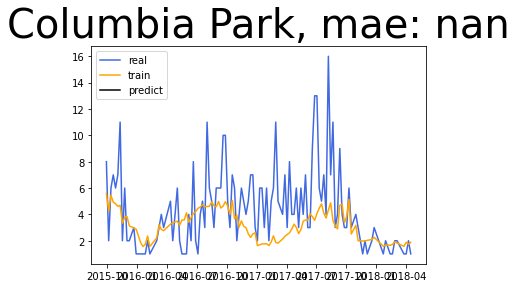

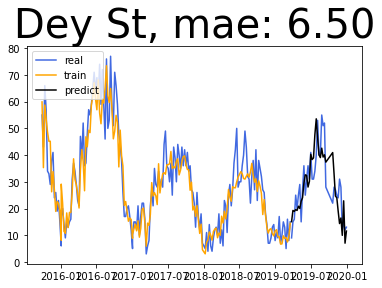

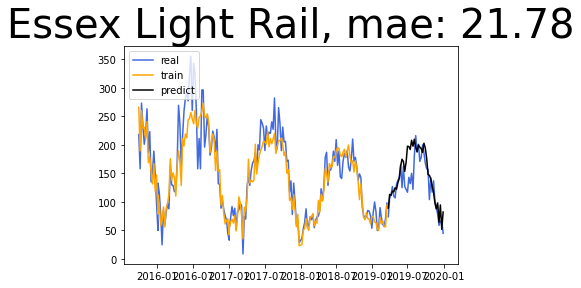

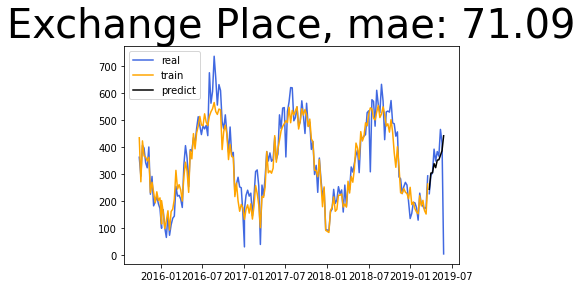

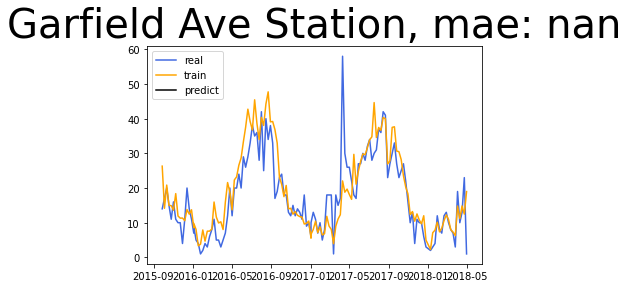

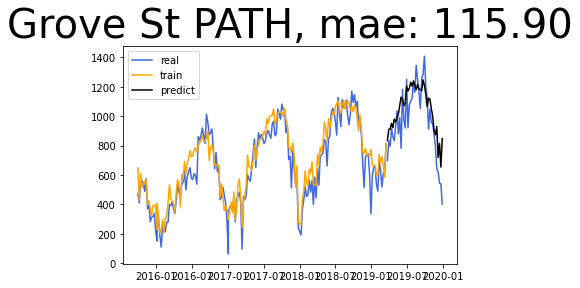

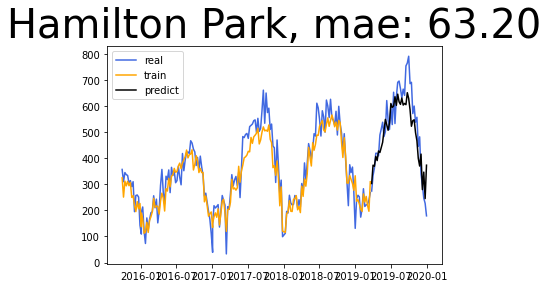

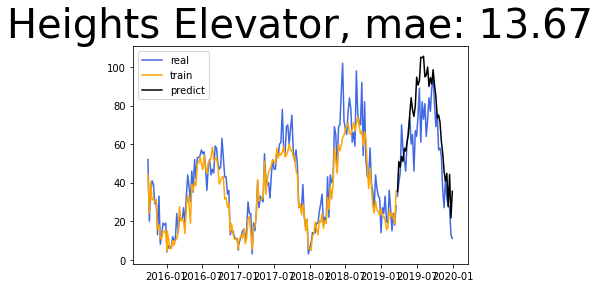

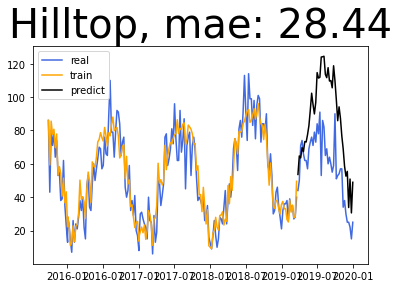

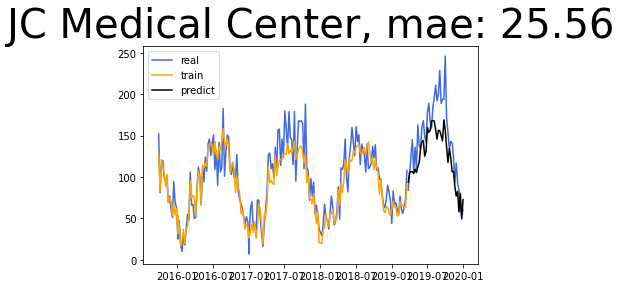

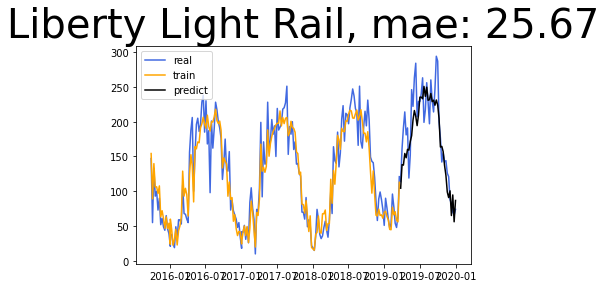

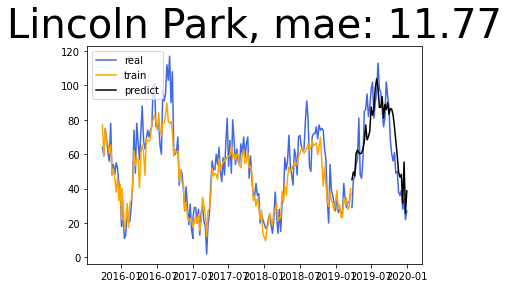

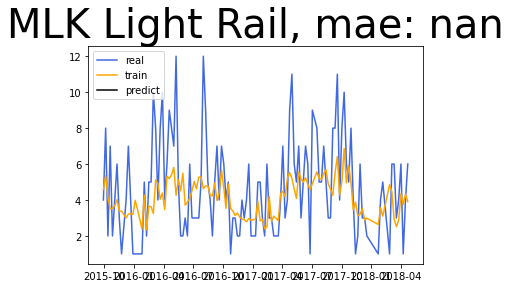

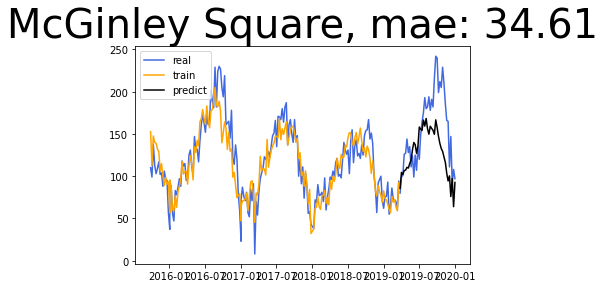

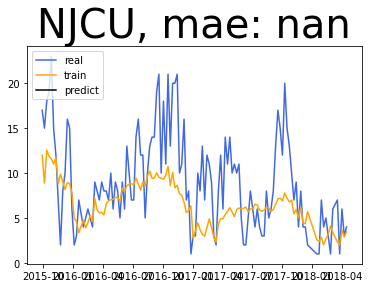

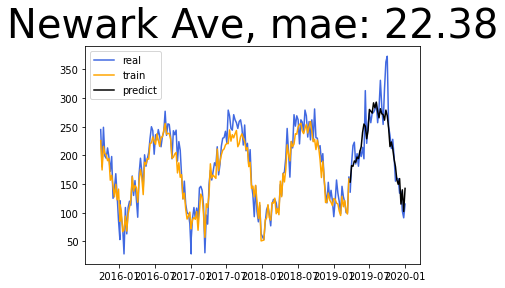

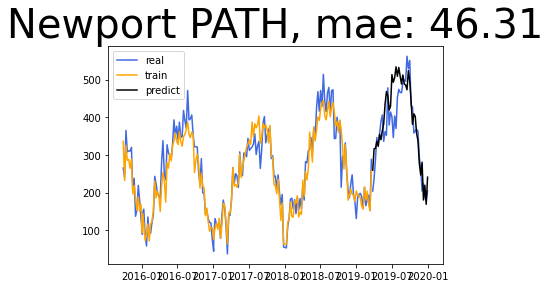

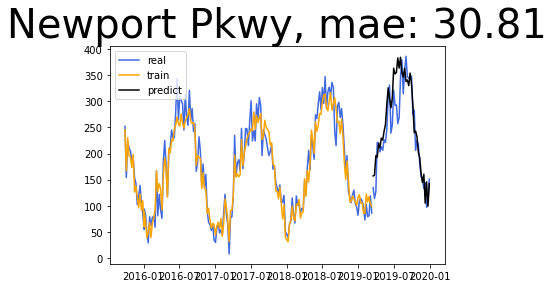

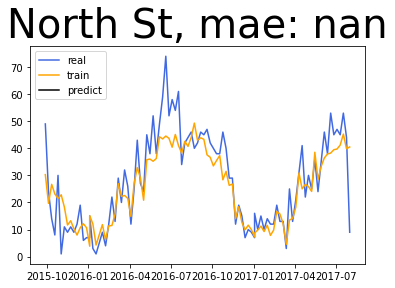

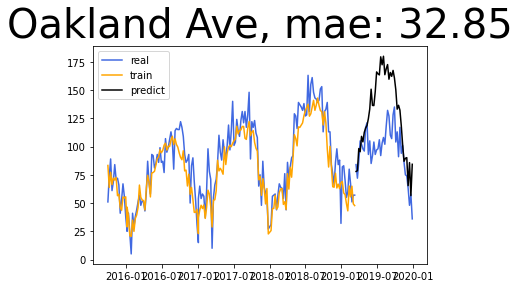

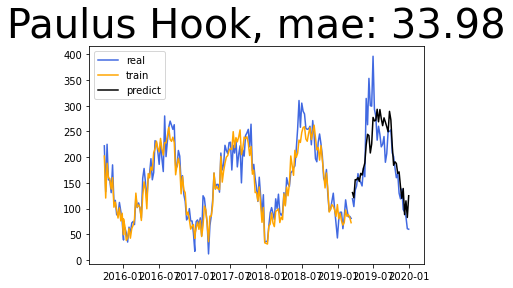

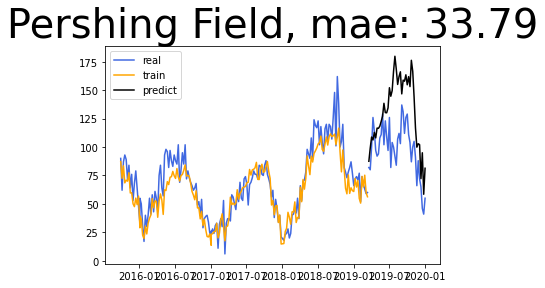

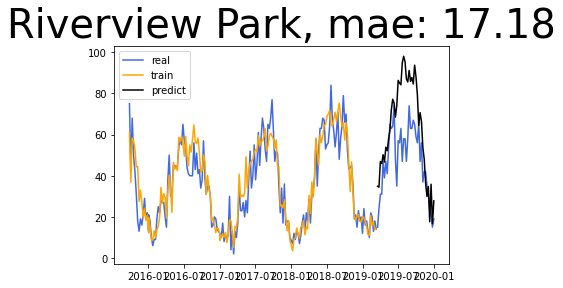

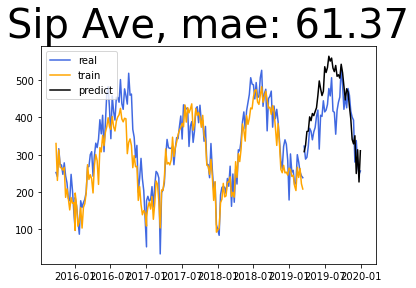

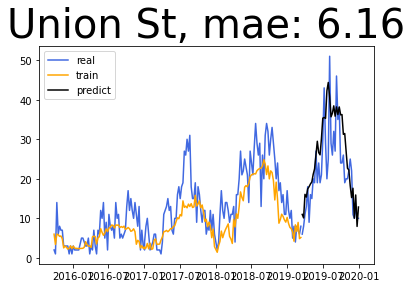

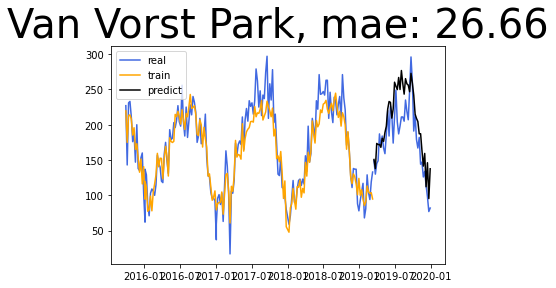

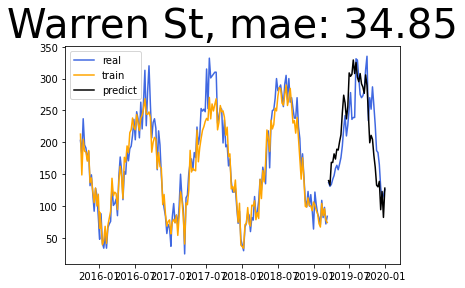

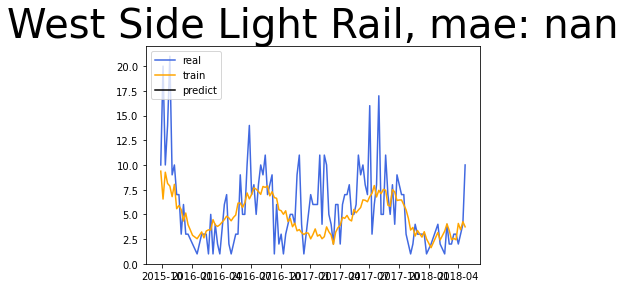

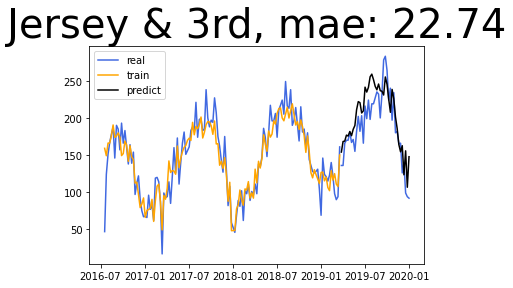

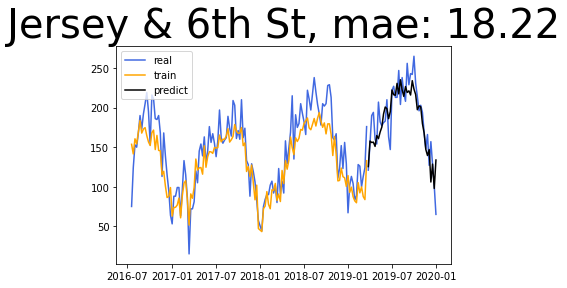

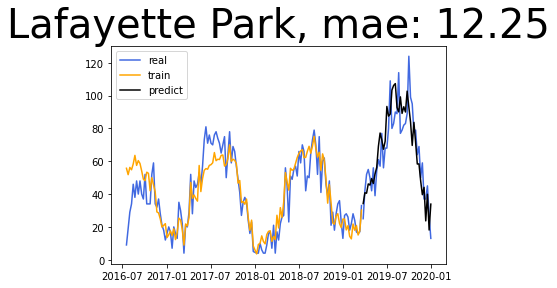

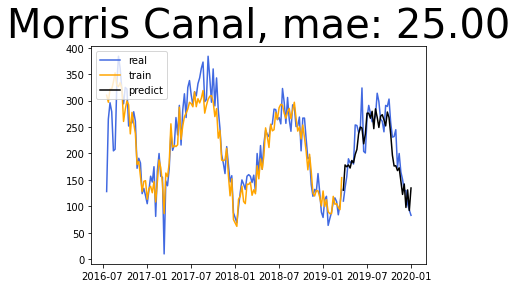

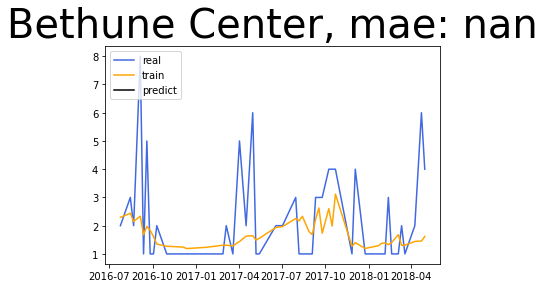

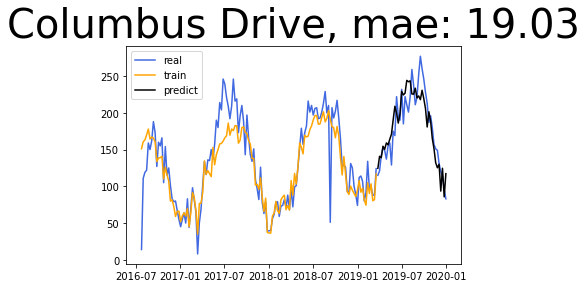

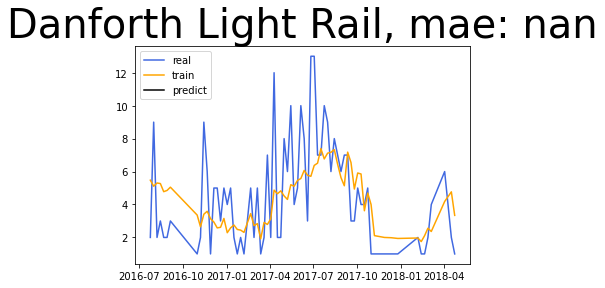

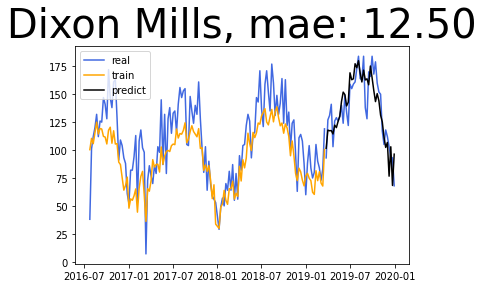

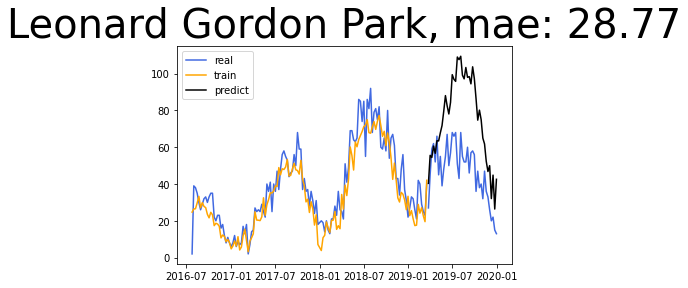

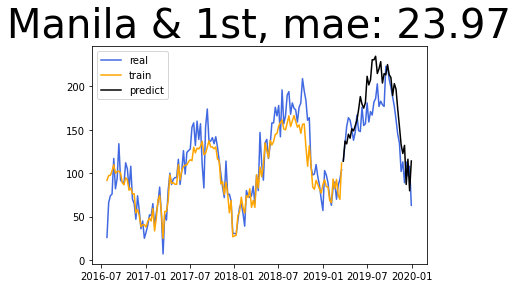

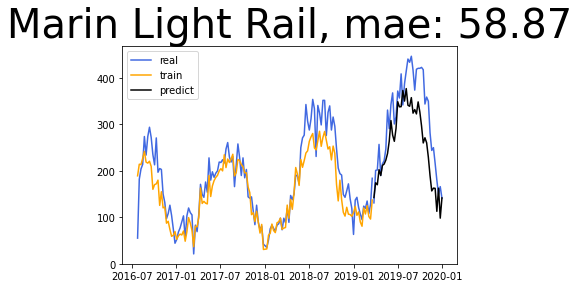

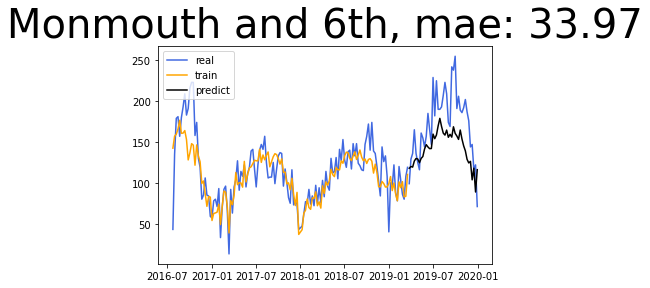

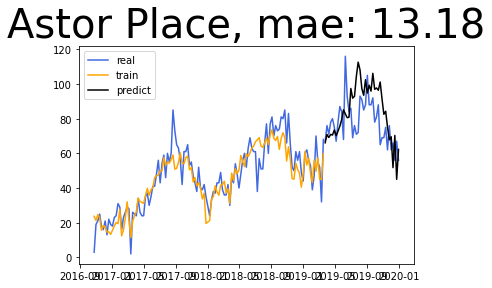

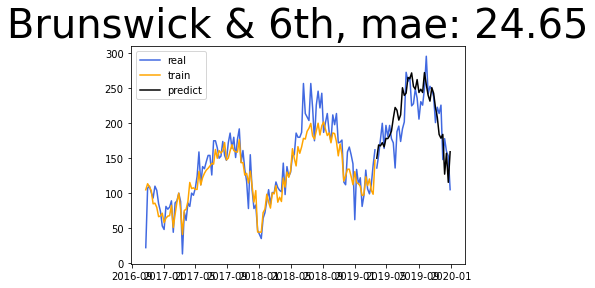

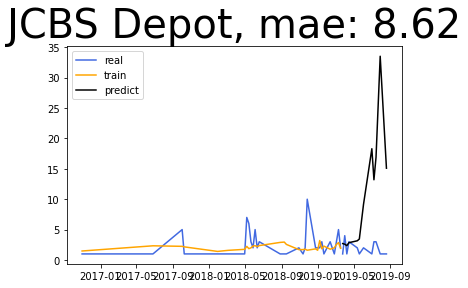

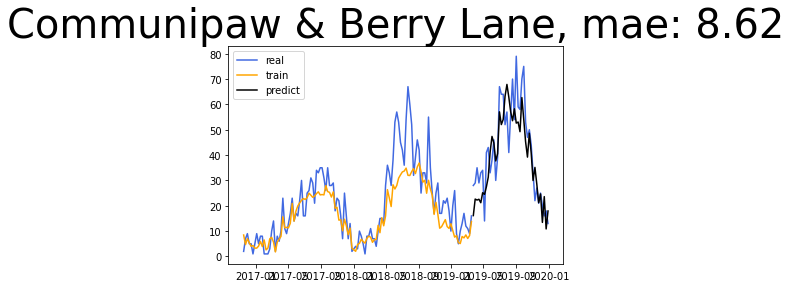

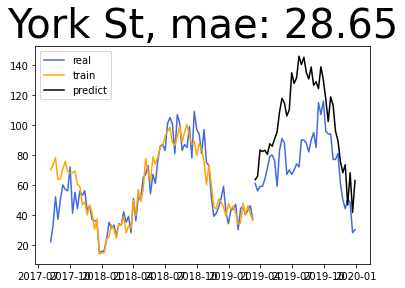

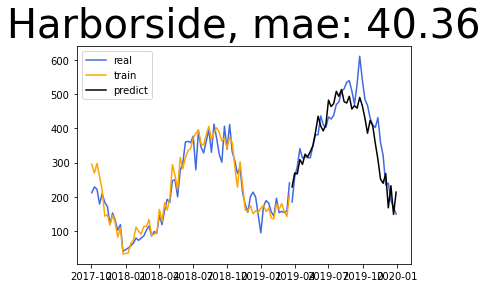

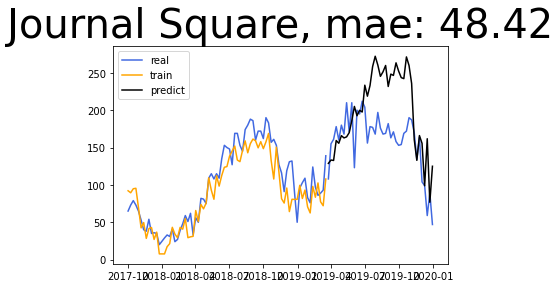

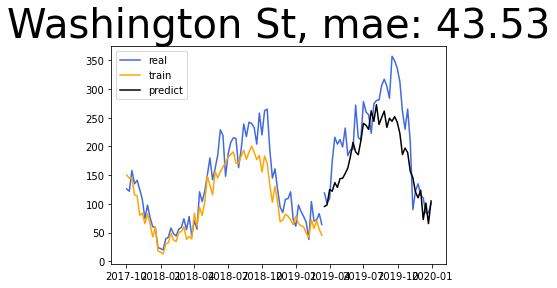

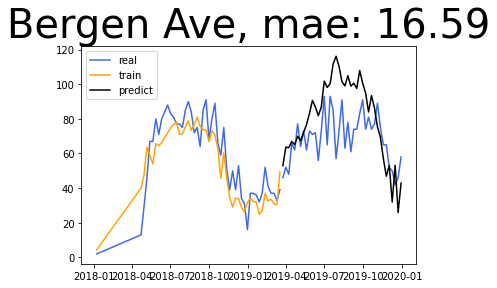

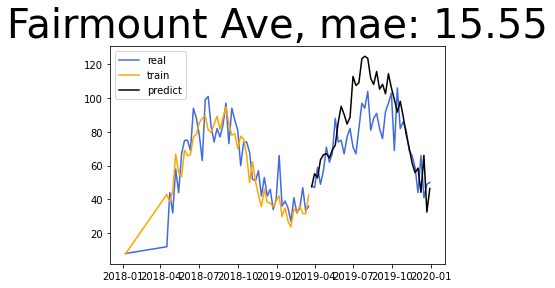

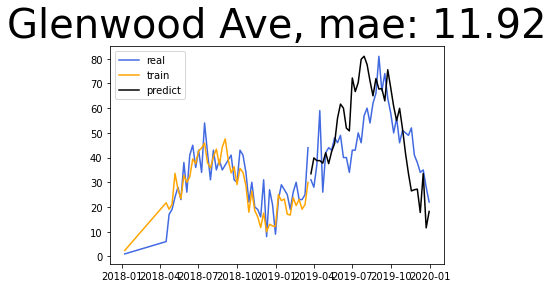

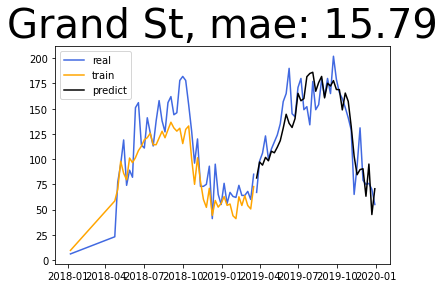

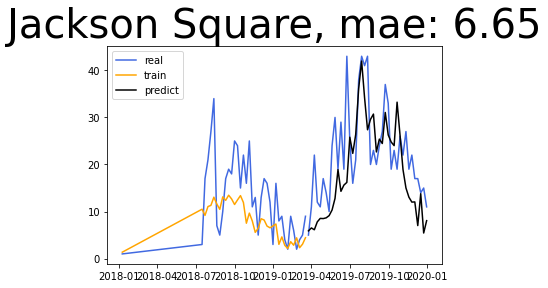

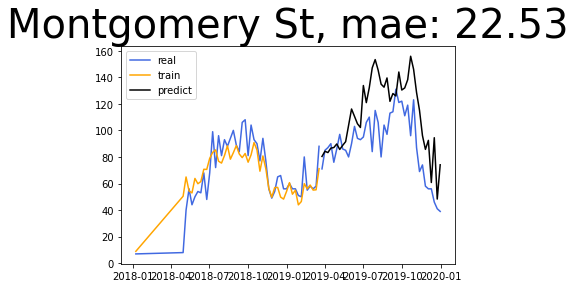

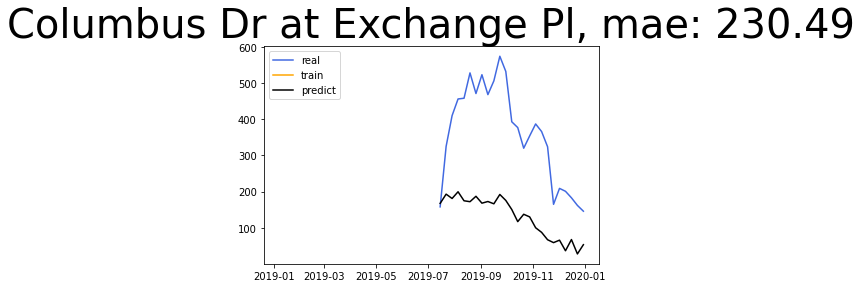

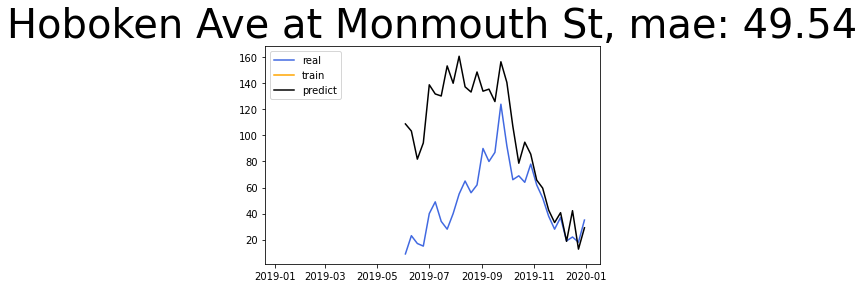

In [126]:
#show result data linear

for station in stationnames:
    predict_train = model.predict(x_train_normalized)
    y1 =  y_train 
    y2 =  predict_train 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#

    test1 = test.iloc[:y_train.shape[0]]
    test1 = pd.DataFrame(test1)
    test1['y'] = y1
    test1['y2'] = y2
    test1 = test1[test1['station']==station]
    test1['yearweek'] = pd.to_datetime(test1['year'].astype(str) + ' ' + test1['week'].astype(str) + ' 1',format='%Y %U %w')
    #print(test1)

    plt.plot(test1['yearweek'],test1['y'],label='real' , color = 'royalblue'  )
    plt.plot(test1['yearweek'],test1['y2'],label='train' , color = 'orange'  )
    predict_test = model.predict(x_test_normalized)
    y1 =  y_test 
    y2 =  predict_test 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#
    test2 = test.iloc[-y_test.shape[0]:]
    test2 = pd.DataFrame(test2)
    test2['y'] = y1
    test2['y2'] = y2
    test2 = test2[test2['station']==station]
    test2['yearweek'] = pd.to_datetime(test2['year'].astype(str) + ' ' + test2['week'].astype(str) + ' 1',format='%Y %U %w')
    #print(test2)
    try:
        mae = mean_absolute_error(test2['y'] ,test2['y2'] )
        plt.title(label=station+", mae: {:0.2f}".format(mae) ,
          fontsize=40,
          color="black")
    except:
        plt.title(label=station+", mae: nan"  ,
          fontsize=40,
          color="black")
    plt.plot(test2['yearweek'],test2['y'],label='_Hidden' , color = 'royalblue'  )
    plt.plot(test2['yearweek'],test2['y2'],label='predict' , color = 'black' )
    
    plt.legend(loc="upper left")
    plt.savefig( 'Model2Images/'+station+'linear.jpg',bbox_inches='tight', dpi=150)
    plt.show()
 

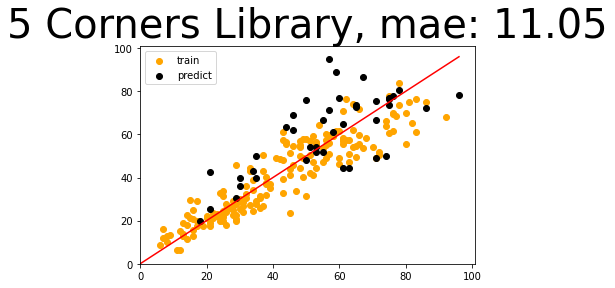

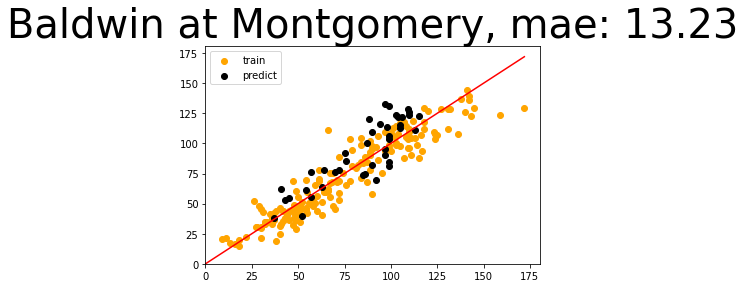

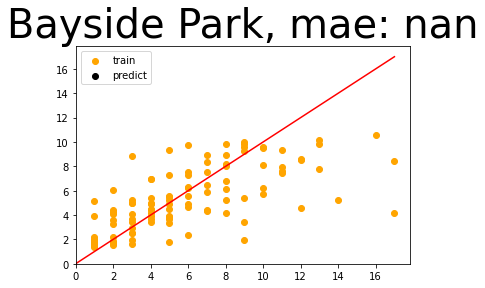

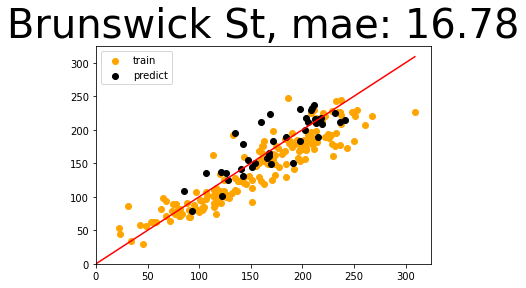

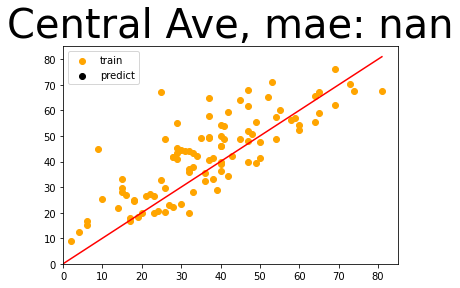

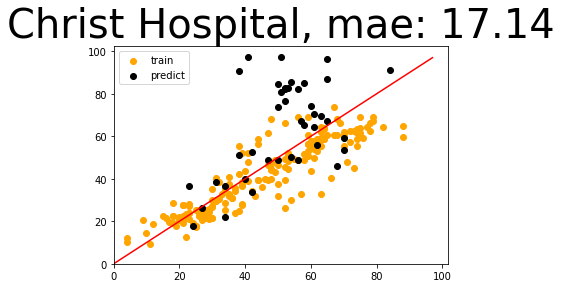

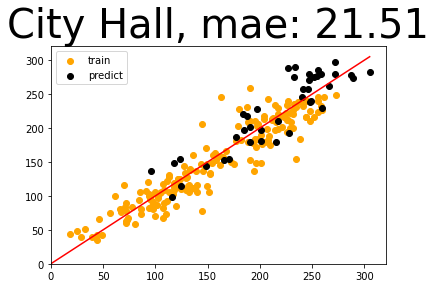

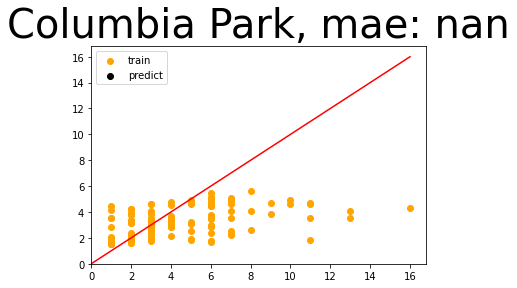

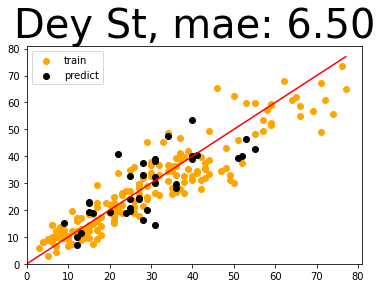

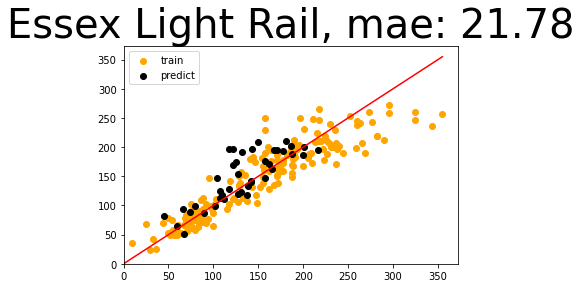

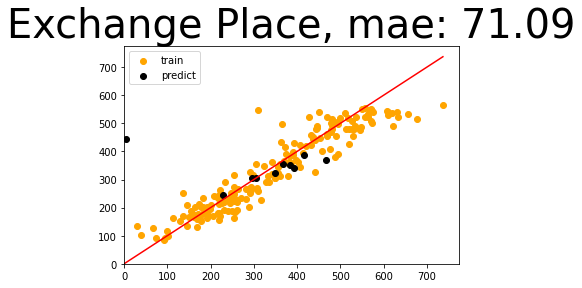

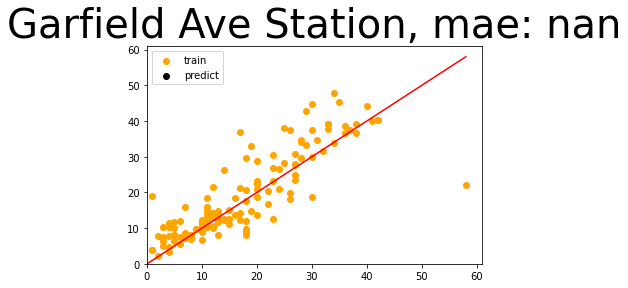

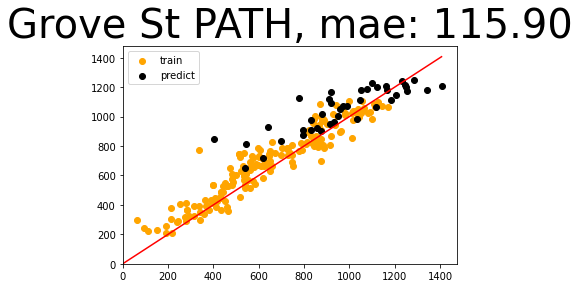

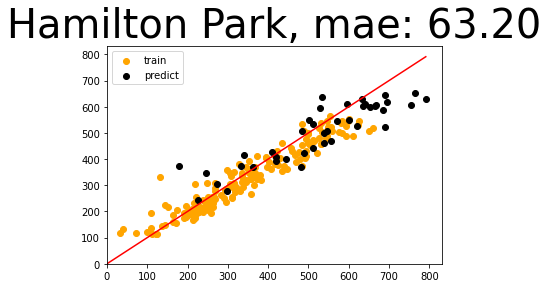

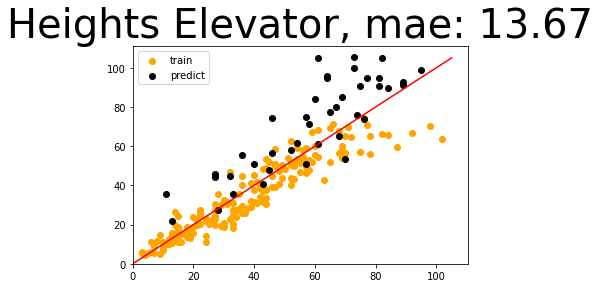

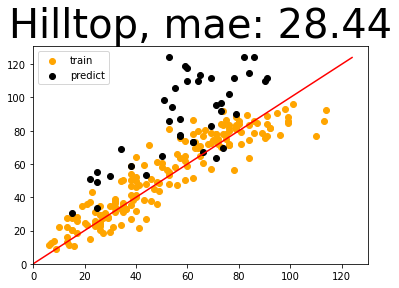

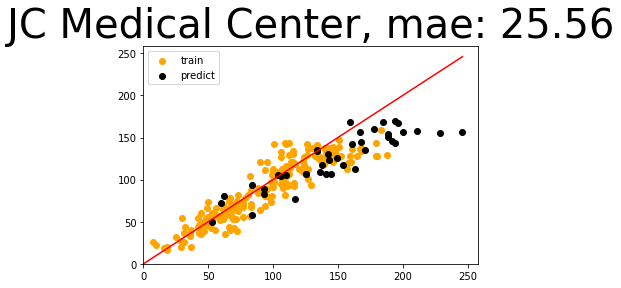

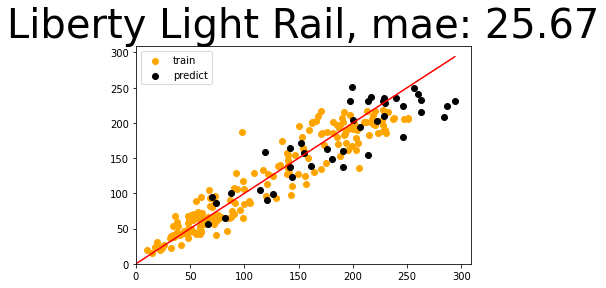

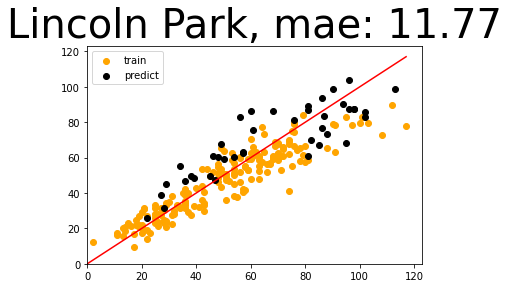

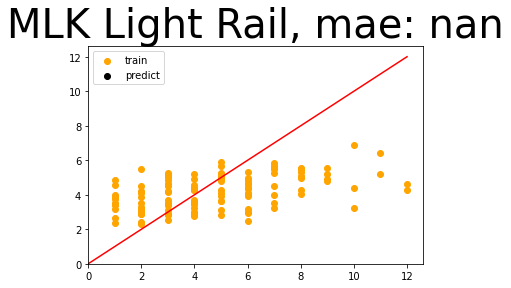

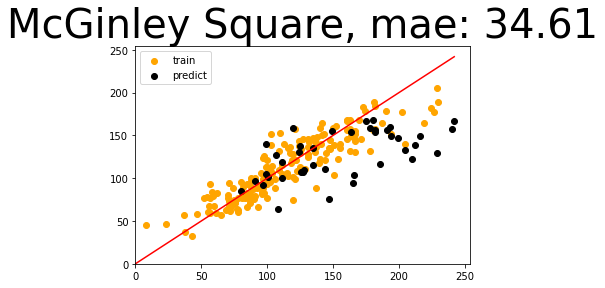

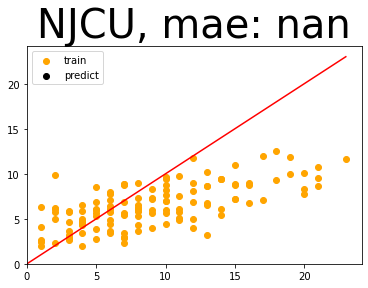

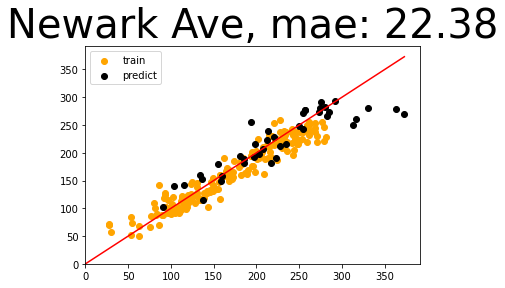

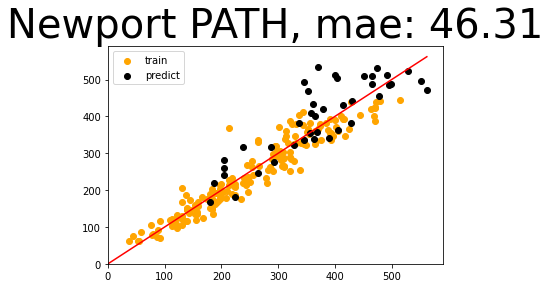

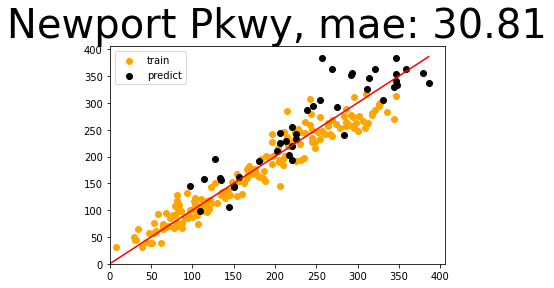

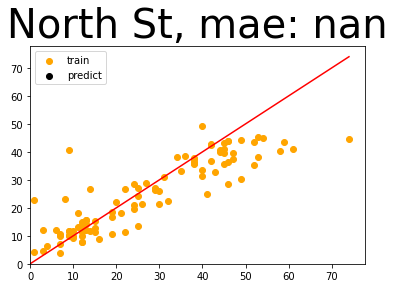

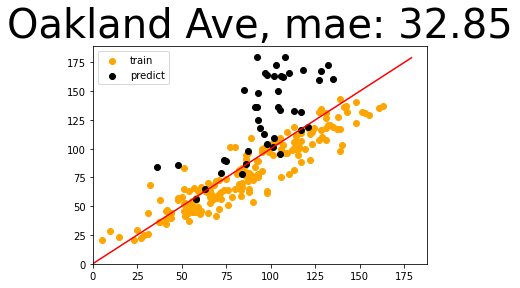

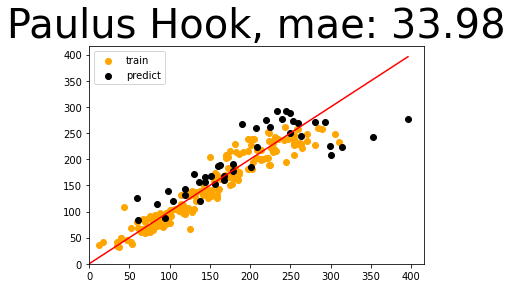

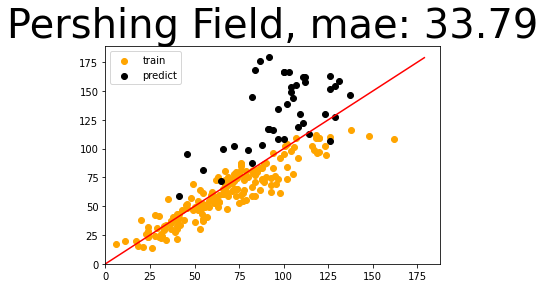

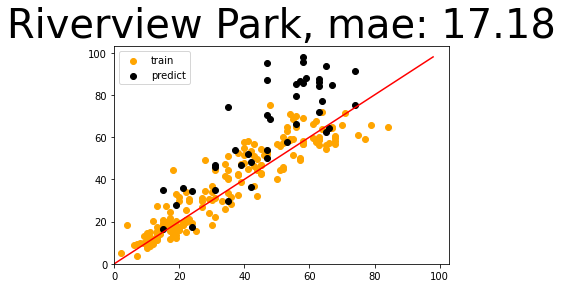

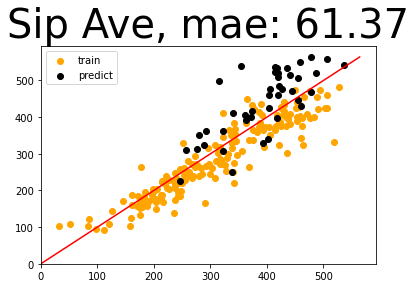

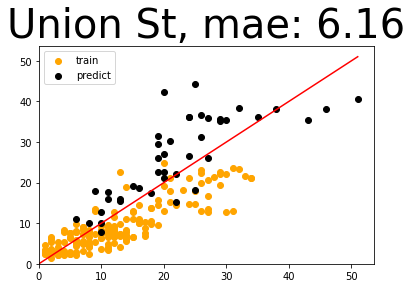

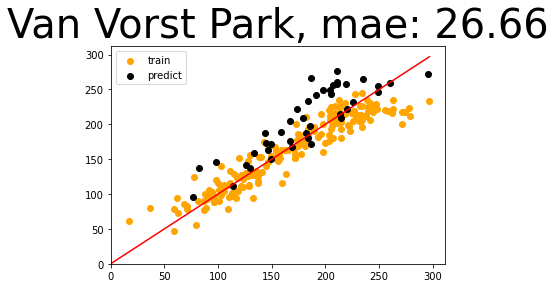

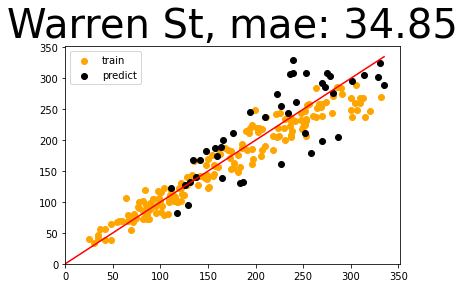

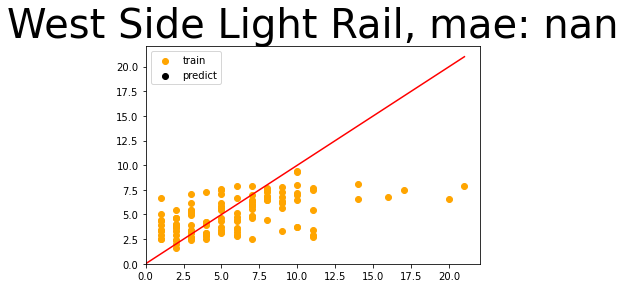

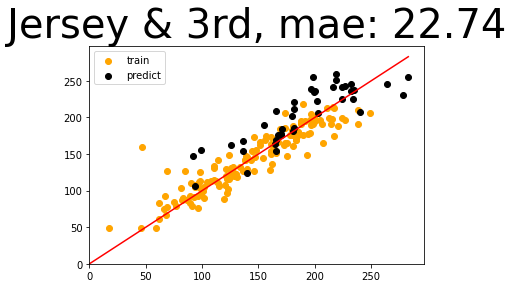

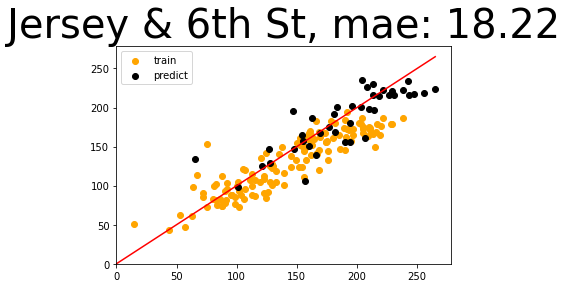

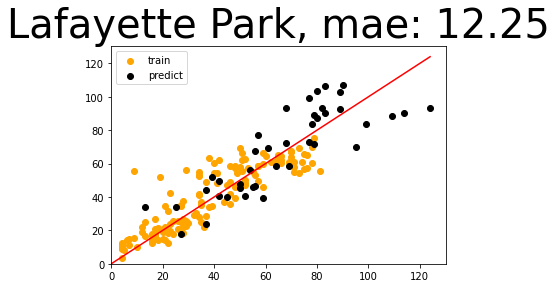

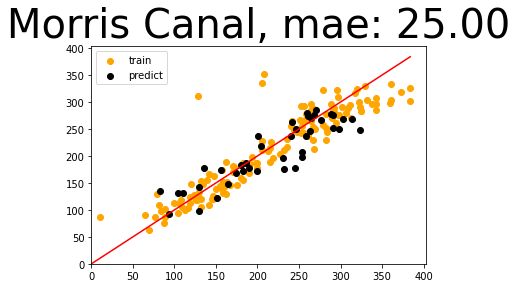

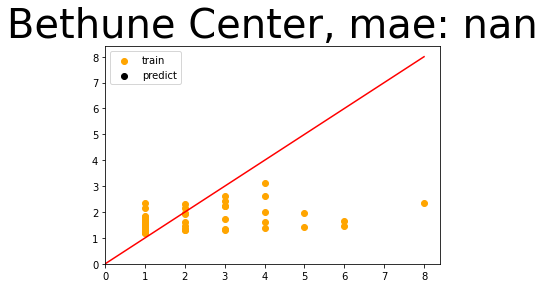

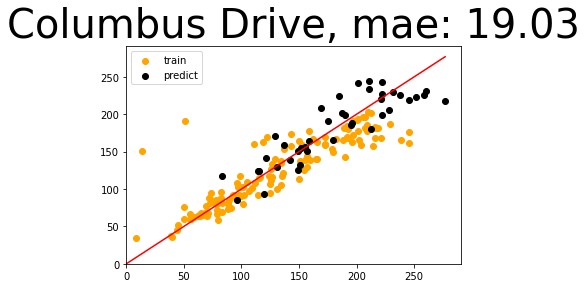

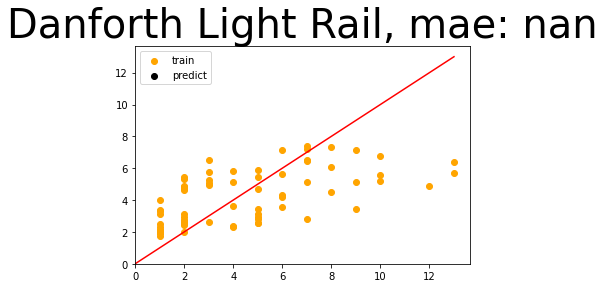

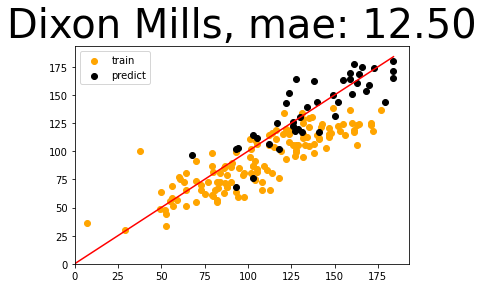

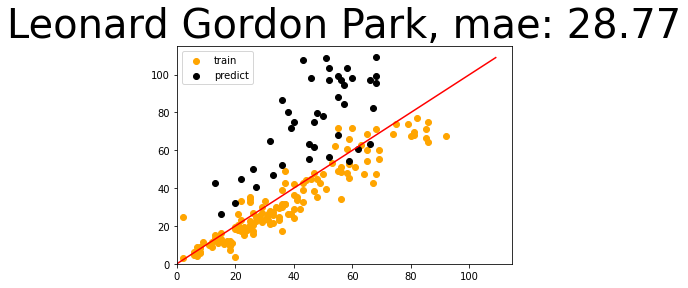

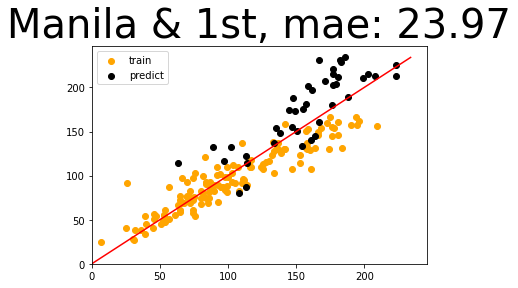

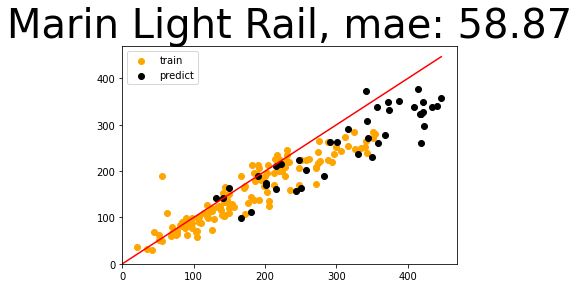

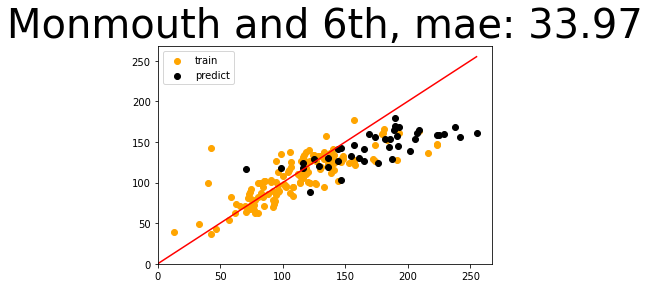

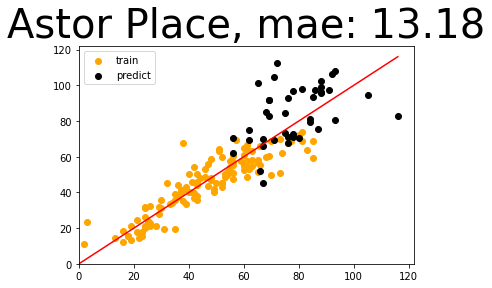

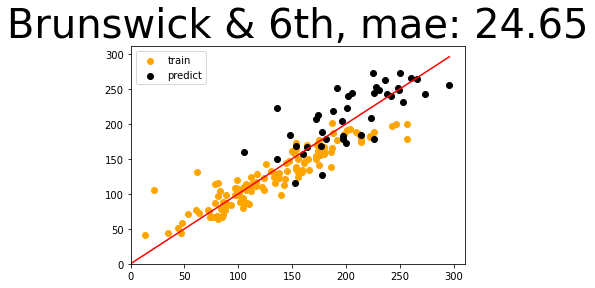

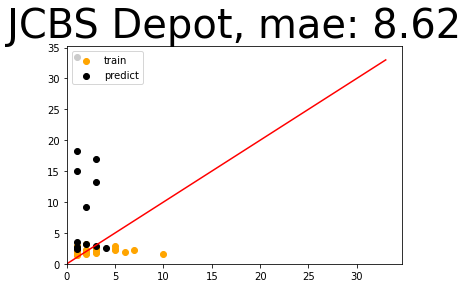

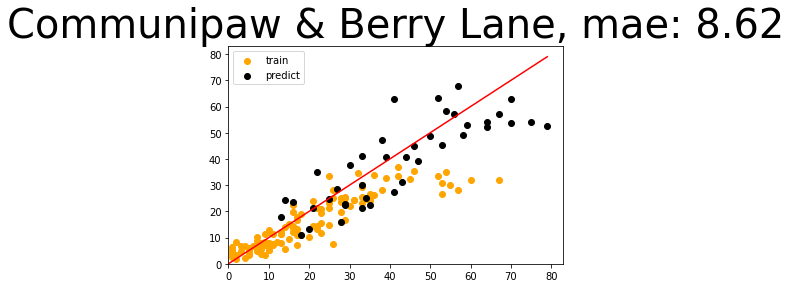

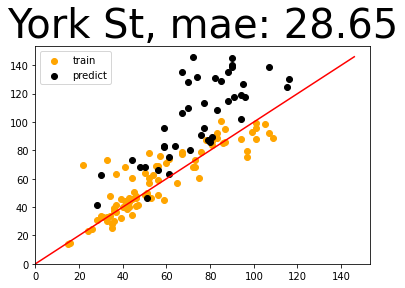

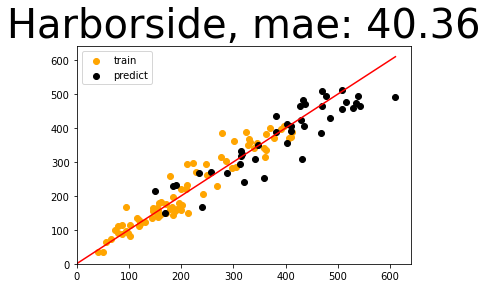

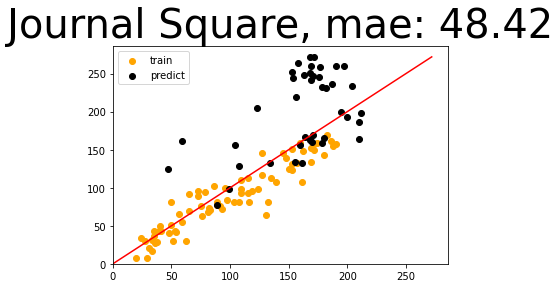

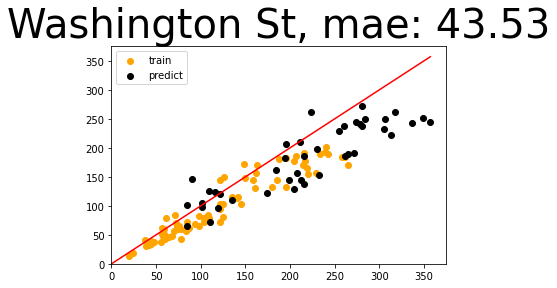

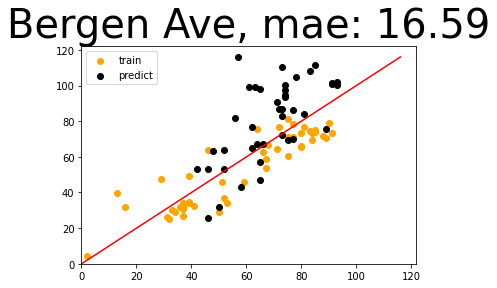

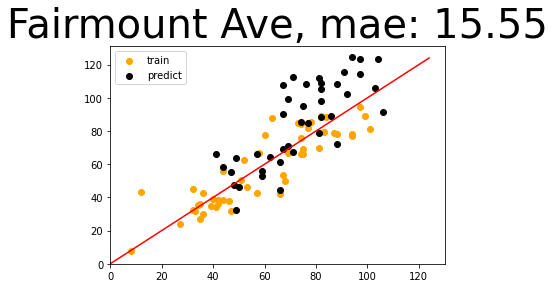

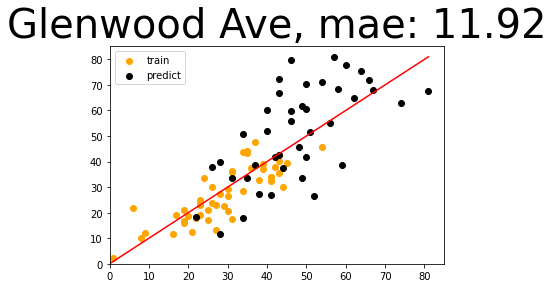

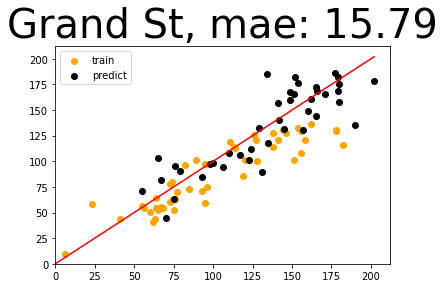

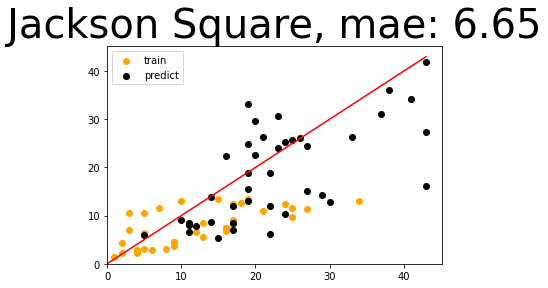

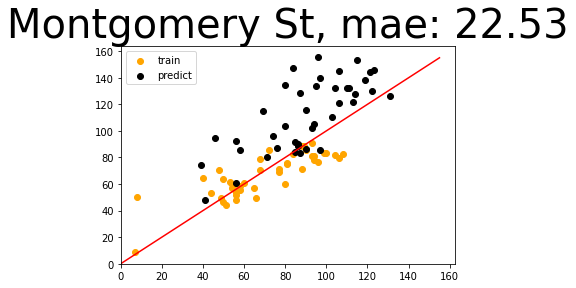

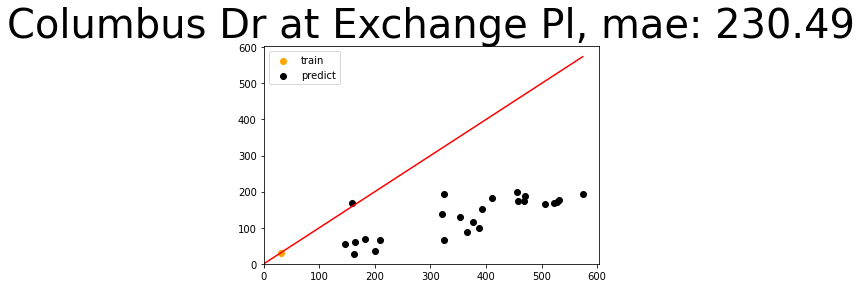

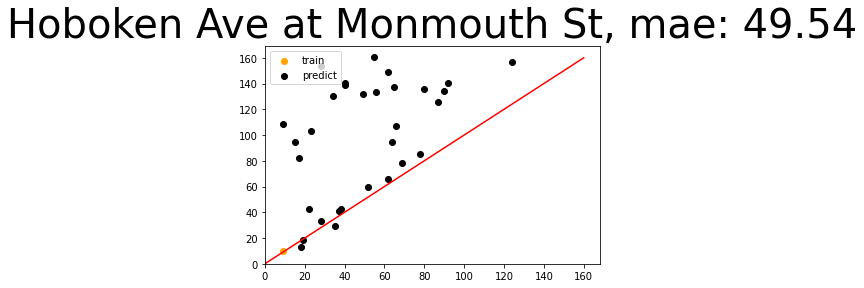

In [127]:
#show result data scatter

for station in stationnames:

    predict_train = model.predict(x_train_normalized)
    y1 =  y_train 
    y2 = predict_train 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#
    
    test1 = test.iloc[:y_train.shape[0]]
    test1 = pd.DataFrame(test1)
    test1['y'] = y1
    test1['y2'] = y2
    test1 = test1[test1['station']==station]
    test1['yearweek'] = pd.to_datetime(test1['year'].astype(str) + ' ' + test1['week'].astype(str) + ' 1',format='%Y %U %w')
    #print(test1)
     
   
    plt.scatter(test1['y'],test1['y2'],label='train' , color = 'orange'  )
    predict_test = model.predict(x_test_normalized)
    y1 =  y_test 
    y2 =  predict_test 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#
    test2 = test.iloc[-y_test.shape[0]:]
    test2 = pd.DataFrame(test2)
    test2['y'] = y1
    test2['y2'] = y2
    test2 = test2[test2['station']==station]
    test2['yearweek'] = pd.to_datetime(test2['year'].astype(str) + ' ' + test2['week'].astype(str) + ' 1',format='%Y %U %w')
    plt.scatter(test2['y'],test2['y2'],label='predict' , color = 'black' )
    #print(test2)
    maxdata1 = (test1['y'].max())if(test1['y'].max() > test1['y2'].max()) else test1['y2'].max()
    maxdata1 = int(maxdata1)
    maxdata2 = (test2['y'].max())if(test2['y'].max() > test2['y2'].max()) else test2['y2'].max()
    maxdata2 = int( 0 if(np.isnan(maxdata2)) else maxdata2)
    maxdata = (maxdata1)if(maxdata1 > maxdata2) else maxdata2
    maxdata = int(maxdata)
    
    try:
        mae = mean_absolute_error(test2['y'] ,test2['y2'] )
        plt.title(label=station+", mae: {:0.2f}".format(mae) ,
          fontsize=40,
          color="black")
    except:
        plt.title(label=station+", mae: nan"  ,
          fontsize=40,
          color="black")
    xline =   np.linspace(0,maxdata,maxdata)
    plt.plot([0,maxdata],[0,maxdata] , color='red')
    plt.ylim(bottom=0)
    plt.xlim(xmin=0)
    plt.legend(loc="upper left")
    plt.savefig( 'Model2Images/'+station+'scatter.jpg',bbox_inches='tight', dpi=150)
    plt.show()

In [21]:
with tf.device('/device:GPU:0'):
    results = model.evaluate(x_test_normalized, y_test.values )
print("Result", results)

66/66 [==============================] - 1s 11ms/step - loss: 36.2101 - mae: 36.2101 - mape: 32.6456
Result [36.21014404296875, 36.21014404296875, 32.645633697509766]


In [125]:
model.save('Model2')

INFO:tensorflow:Assets written to: Model2/assets
